# Implementing a Neural Network with PyTorch
-------------------------

We finally made it to the last chapter in this book. It hasn't been a long journey, but it's definitely been dense.

In this chapter, we're going to be looking at the same dataset as last chapter, but this time, we'll run it through a neural network. So what's all this fancy talk about neural networks? Maybe a diagram will better explain it. Before we go into the diagram, let's import some libraries along with the dataset.

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

df = pd.read_csv(r'https://raw.githubusercontent.com/a-coders-guide-to-ai/a-coders-guide-to-neural-networks/master/data/diabetes.csv')

## 5.1 A Neural Network Diagram

Up until now, we've seen a couple computation graphs and we've also seen the simplified computation graph for logistic regression. The graph represented the architecture of our algorithms. I'll present to you the architecture for our neural network. Let's take a look...

Just a note - although there are many types of neural networks, the kind of neural network we'll be looking at is a feed forward network. It's also often commonly referred to as a fully connected neural network.

<img src="images/neural%20network.png?raw=true"  width="500" height="500">

It's a little confusing but let me explain. What you're seeing are the 8 features on the left, which are represented by 8 circles (i.e., neurons). You're probably wondering what happened to our neuron with the 1 (i.e., the 9th neuron for the bias) we saw in the last diagram. In practice, the 1 which is multiplied by the bias isn't shown, it's assumed to be present at every layer, including the input layer. We see the 8 features on the left, but unlike last time, we see 4 neurons in the middle and each of our 8 features go into all the 4 neurons. What does that mean? Remember when we did logistic regression, the 1 middle neuron represented the logistic regression equation being performed on the 8 features. This time, we have 4 separate logistic regression equations (the same equation) being performed on the 8 features, in parallel. Wouldn't that make 4 equations with the same outcome? Not if we start with randomly assigned weights. In the previous chapters, we always started with all the weights equal to 0. Starting with the weights all set to 0 at the beginning would give us 4 equations with the same outcome but starting with randomly assigned weights will give us 4 different outcomes. Those 4 outcomes are then used as the new features which feed into the last neuron, providing us with our prediction.

I know, the above was confusing, but it'll make more sense when we walk through it with code.

In [2]:
hidden_nodes = 4
amount_of_features = 8
torch.random.manual_seed(1234)
hidden_weights = torch.rand((hidden_nodes, amount_of_features+1), dtype=float, requires_grad=True)
torch.random.manual_seed(1234)
output_weights = torch.rand((1, hidden_nodes+1), dtype=float, requires_grad=True)

Let's go through the code above. You'll see that we have a variable named hidden_nodes, which is set to 4. This variable holds the number of nodes our first and only hidden layer will have. Just a side note, every layer that comes between your input layer and output layer are known as hidden layers. We only have 1 hidden layer in our architecture, but it's possible, and very normal, to have many more. Our amount_of_features variable holds the number of features, which we feed into our neural network (i.e., the input layer).

Moving on to the less obvious part of the code, we set random's manual_seed to 1234. Setting the manual seed allows the randomness to be regenerated. It's so that when others run the code, they end up with the exact same random numbers (yes, I know, that's the complete opposite of random, but it comes in handy for times like this). We chose the numbers 1234 but could have chosen any set of numbers. I currently don't know if there's a better way to do this, so I set it every time I make random variables, in order to make the code reproduceable.

The last things are our actual weight tensors - hidden_weights and output_weights. The 2 tensors are randomly generated. The hidden_weights tensor has the shape [4 x 9] and the output_weights tensor has the shape [1 x 5]. If you refer to our neural network architecture diagram, you'll find that the transpose of the shapes of our tensors is exactly how our architecture is defined. Our 8 features (+1 bias, making it 9) go into 4 nodes, and then our 4 nodes (+1 bias, making it 5) go into our final output node, which is 1. To simplify, our hidden_weights tensor accepts 9 features and outputs 4, while our output_weights tensor accepts 5 features and outputs 1.

Hope that makes sense. Let's look at it through code.

## 5.2 Implementing a Neural Network

Let's start implementing the code for our neural network. We'll begin with converting our data to tensors.

In [3]:
X = df[df.columns[:-1]]
y = df['Outcome']
X = torch.tensor(X.values)
y = torch.tensor(y.values)
X = torch.cat((X, torch.ones(X.shape[0], dtype=float).reshape(-1,1)), dim=1)

In [4]:
def BCE(y, y_pred): ##log loss error (binary cross entropy)
  return -torch.sum((y*torch.log(y_pred) + (1-y)*torch.log(1-y_pred)))/y.shape[0]

def sigmoid(linear):
    return 1/(1+torch.exp(-linear))

def accuracy(y_pred, y):
    return torch.sum((((y_pred>=0.5)+0).reshape(1,-1)==y)+0).item()/y.shape[0]

In [5]:
epoch_loss = []

learning_rate = 1e-3
n = X.shape[0]

for epoch in range(5000+1): 
    ##hidden layer##
    hidden_linear = hidden_weights@X.T
    hidden_output = sigmoid(hidden_linear)
    hidden_output = torch.cat((hidden_output, torch.ones(hidden_output.shape[1], dtype=float).reshape(1,-1)), dim=0)
    ################
    output_linear = output_weights@hidden_output
    y_pred = sigmoid(output_linear)
    loss = BCE(y, y_pred)
    epoch_loss.append(loss.item())

    ###backpropagation###
    loss.backward()

    ###step###
    with torch.no_grad():
        hidden_weights -= learning_rate * hidden_weights.grad
        output_weights -= learning_rate * output_weights.grad

    hidden_weights.grad.zero_()
    output_weights.grad.zero_()

    if(epoch % 1000 == 0):
        print('epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, epoch_loss[-1], accuracy(y_pred, y)))
    

epoch: 0 - loss: 1.21681; acc: 0.349
epoch: 1000 - loss: 0.70034; acc: 0.349
epoch: 2000 - loss: 0.65160; acc: 0.651
epoch: 3000 - loss: 0.64727; acc: 0.651
epoch: 4000 - loss: 0.64685; acc: 0.651
epoch: 5000 - loss: 0.64680; acc: 0.651


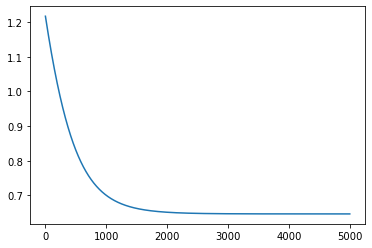

In [6]:
plt.plot(epoch_loss)

That's odd, we're only getting an accuracy of 65%... I thought neural networks were supposed to be state of the art. Why are our results worse than our vanilla logistic regression from the last chapter? The truth is, neural networks do in fact often outperform traditional machine learning techniques, but there are a few tricks needed to really get those results. Before we dive into those tricks, let's go over splitting our dataset.

## 5.3 Train/Test Split

If you've been studying machine learning for some time, then you must have heard of splitting a dataset into train and test. It's a mandatory practice which we've skipped up until now. For those who haven't heard of it, I think an analogy would be useful. 

How does a student practice for a test? They study the material taught throughout the semester, expecting that their studies will give them enough of an understanding of the subject that they can deduce the answers to respond to the questions on the test. The test usually doesn't have the exact same word for word questions which were taught throughout the semester. Rather, the test has questions which test the student on their understanding of the material taught throughout the semester. Had the test just consisted of questions which were word for word the exact same as those which were taught throughout the semester, then the student would just memorize those questions and not care for actually understanding the material. 

Sorry, that was a super long analogy, but splitting our data into a training set and a testing set is much of the same as our analogy above. So far, we've been testing our model on the exact same data which we trained it on. That’s like giving the answers before the questions. The real way to tell if our model is good at predicting is to show it data that it’s never seen before. How do we do that? Simple. We just take our dataset and randomly set aside a percentage of the rows for testing. Those testing rows are rows in the dataset which our model has never seen before, but because our model should have gotten a good idea of our domain of interest from the training data, it should be able to deduce the answers (i.e., predict) for the testing data - just like the student.

The steps needed to perform this is to randomly shuffle the dataset and then set aside a portion of the data. It allows our testing set to have the same representation as our training set. We could write this from scratch, but it's better (and easier) to use scikit-learn's built-in train_test_split function.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

You can see from the one-liner above why I recommended scikit-learn's function, rather than writing our own. It's super straightforward. There's maybe only 1 thing that needs a bit of explaining. The test_size is set to 0.33. That's us telling the function to allocate 1/3 (~33%) of the data for the test set and the rest of the data for the train set.

Now that we've covered that, let's move onto a trick that will help our neural network outperform logistic regression.

## 5.4 Standardization

There are several tricks we can use to ensure our neural networks performs better, but in this chapter, we'll be discussing standardization. Standardizing your features is a good starting point before throwing them into any neural network. Standardization is a data scaling method to center your data around 0 (mean of 0) and have the standard deviation to be 1. It forces 95% of your data for the standardized feature to fit between the values -2 and 2, while keeping the mean at 0. Let's look at an example.

(array([395.,  92.,  88.,  67.,  51.,  19.,  18.,  12.,   4.,   4.,   2.,
          7.,   4.,   1.,   1.,   0.,   1.,   1.,   0.,   1.]),
 array([  0. ,  42.3,  84.6, 126.9, 169.2, 211.5, 253.8, 296.1, 338.4,
        380.7, 423. , 465.3, 507.6, 549.9, 592.2, 634.5, 676.8, 719.1,
        761.4, 803.7, 846. ]),
 <a list of 20 Patch objects>)

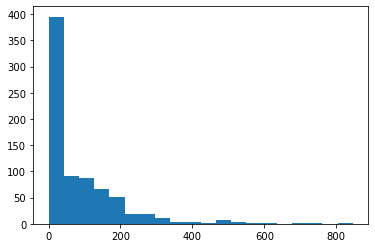

In [8]:
import matplotlib.pyplot as plt

insulin = list(df.columns).index('Insulin')
plt.hist(X.T[insulin], bins=20)

In [9]:
X_mean = torch.mean(X, axis=0)
X_std = torch.std(X, axis=0)
X_standardized = (X-X_mean)/X_std

(array([395.,  92.,  88.,  67.,  51.,  19.,  18.,  12.,   4.,   4.,   2.,
          7.,   4.,   1.,   1.,   0.,   1.,   1.,   0.,   1.]),
 array([-0.69243932, -0.32539202,  0.04165528,  0.40870258,  0.77574988,
         1.14279718,  1.50984448,  1.87689178,  2.24393908,  2.61098638,
         2.97803368,  3.34508098,  3.71212829,  4.07917559,  4.44622289,
         4.81327019,  5.18031749,  5.54736479,  5.91441209,  6.28145939,
         6.64850669]),
 <a list of 20 Patch objects>)

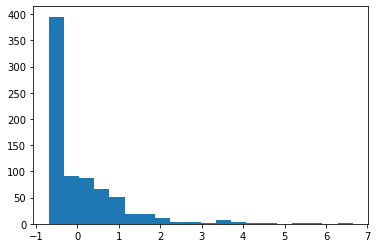

In [10]:
plt.hist(X_standardized.T[insulin], bins=20)

Just to explain what we're doing above. In our example, we took the insulin feature in our data and plotted it before and after standardizing. The equation for standardizing is very simple. To quickly go over the equation, all we did is find the mean and the standard deviation for each column (that's why we're using axis=0) and then subtracting each column by its respective standard deviation and dividing by its respective mean. You can see that the distribution of the data (i.e., the way the data is spread) hasn't changed after standardizing it, but as stated above, 95% of the data now fits in the range of -2 to 2, whereas before, 95% of the data was between 0 and 400.

So why does this matter? It matters because when we have a wide range of numbers, especially amongst multiple features, it becomes harder for our model to reach optimal values. When we restrict the range of the numbers and make them consistent across all the features, our model has a much easier time to find a more optimal solution.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = torch.tensor(scaler.transform(X_train))
X_test = torch.tensor(scaler.transform(X_test))

Instead of manually standardizing our features, it's better to use scitkit-learn's built-in StandardScaler class. It's simple to use and gives us the same result, but that's not entirely the reason as to why it's better to use. If you take a look at the code cell above, you'll see that I fit the scaler variable to X_train but transformed on both X_train and X_test. The reason for this is that, because we don't want to use anything from our testing set, not even the mean or standard deviation. We want everything from our training set and then to transfer our findings, including the mean and standard deviation, to our testing set.

In [12]:
torch.random.manual_seed(1234)
hidden_weights = torch.rand((hidden_nodes, amount_of_features+1), dtype=float, requires_grad=True)
torch.random.manual_seed(1234)
output_weights = torch.rand((1, hidden_nodes+1), dtype=float, requires_grad=True)

train_loss = []
test_loss = []

learning_rate = 1e-2
n = X_train.shape[0]

for epoch in range(50000+1): 
    ##hidden layer##
    hidden_linear = hidden_weights@X_train.T
    hidden_output = sigmoid(hidden_linear)
    hidden_output = torch.cat((hidden_output, torch.ones(hidden_output.shape[1], dtype=float).reshape(1,-1)), dim=0)
    ################
    output_linear = output_weights@hidden_output
    y_pred = sigmoid(output_linear)
    loss = BCE(y_train, y_pred)
    train_loss.append(loss.item())

    ###backpropagation###
    loss.backward()

    ###step###
    with torch.no_grad():
        hidden_weights -= learning_rate * hidden_weights.grad
        output_weights -= learning_rate * output_weights.grad

    hidden_weights.grad.zero_()
    output_weights.grad.zero_()
    
    if(epoch % 10000 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, train_loss[-1], accuracy(y_pred, y_train)))
    
    ####run model on test set####
    hidden_linear = hidden_weights@X_test.T
    hidden_output = sigmoid(hidden_linear)
    hidden_output = torch.cat((hidden_output, torch.ones(hidden_output.shape[1], dtype=float).reshape(1,-1)), dim=0)
    output_linear = output_weights@hidden_output
    y_pred = sigmoid(output_linear)
    loss = BCE(y_test, y_pred)
    test_loss.append(loss.item())

    if(epoch % 10000 == 0):
        print('Test: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, test_loss[-1], accuracy(y_pred, y_test)))

Train: epoch: 0 - loss: 0.88983; acc: 0.354
Test: epoch: 0 - loss: 0.91004; acc: 0.339
Train: epoch: 10000 - loss: 0.46387; acc: 0.774
Test: epoch: 10000 - loss: 0.50369; acc: 0.732
Train: epoch: 20000 - loss: 0.45186; acc: 0.774
Test: epoch: 20000 - loss: 0.50526; acc: 0.752
Train: epoch: 30000 - loss: 0.44288; acc: 0.774
Test: epoch: 30000 - loss: 0.50134; acc: 0.760
Train: epoch: 40000 - loss: 0.43863; acc: 0.776
Test: epoch: 40000 - loss: 0.50160; acc: 0.764
Train: epoch: 50000 - loss: 0.43640; acc: 0.784
Test: epoch: 50000 - loss: 0.50205; acc: 0.764


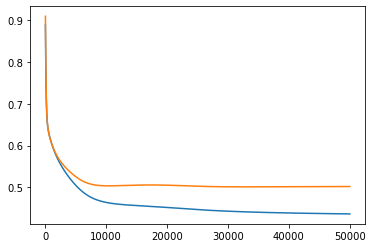

In [13]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

You can see the noticeable effect standardizing has on the data. Even though we're training with less data, we're getting significantly better results. 78% accuracy on our training set and 76% accuracy on our test set. That's much better than we received before standardizing and noticeably better than our logistic regression algorithm.

Onto the last section of this book, where we go over the PyTorch framework.

## 5.5 PyTorch Framework

We've made it to the last section of this book! We've already seen some of the advantages of using PyTorch, but here's arguably the greatest advantage of using PyTorch – the PyTorch framework.

We're going to take a look at how easy it is to write the neural network code from above using the PyTorch framework.

First thing we're going to do is import torch.nn. This is going to allow us to take advantage of its robust and easy-to-use functionality.

In [14]:
import torch.nn as nn

Next, we're going to create a class that will inherit nn.Module. That's what allows us to use PyTorch's functionality. Our class must always consist of at least 2 functions - an init function and a forward function.

As for the init function, its main purpose is to declare the components to our neural network architecture. For our case, we know that we have 3 layers. The first layer is the input layer, the second is the hidden layer and the last is our output layer. We need to define the size of all the layers after the input layer (2 in our case) along with which activation function(s) we'll be using. In our case, we have 2 linear layers and only 1 activation function (by the way, the sigmoid function is a type of activation function). Starting from the second layer, looking at our architecture diagram above, we know that it accepts 8 features and condenses them to 4. As for our last layer, it accepts 4 features and condenses them down to 1 (i.e., our prediction). For our case, the activation function for our linear layers is always the sigmoid function. If you look below, you'll see that all of that is provided in our init function.

The forward function's purpose is to define the actual architecture. It lets the class know how our components in our init function work together to create our architecture. Looking below, you will see that our hidden layer goes into our sigmoid function, creating our hidden_output variable, thereafter our hidden_output variable goes into the last linear layer and through the final activation function, providing us with our output (i.e., prediction).

In [15]:
class Model(nn.Module):
    
    def __init__(self, hidden_nodes, amount_of_features):
        super().__init__()
        self.hidden_linear = nn.Linear(amount_of_features, hidden_nodes)
        self.output_linear = nn.Linear(hidden_nodes, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        hidden_output = self.sigmoid(self.hidden_linear(X))
        output = self.sigmoid(self.output_linear(hidden_output))
        return output

We'll be using our hidden_nodes and amount_of_features variables from above to pass to our Model class. You can also see how easy it is to declare our loss function and gradient descent algorithm using PyTorch's native functionality. Instead of using our binary cross entropy function which we wrote ourselves, we'll use PyTorch's. Also, we'll use PyTorch's stochastic gradient descent (SGD), passing our gradient weights along with the learning rate.

In [17]:
model = Model(hidden_nodes, amount_of_features)
BCE = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

This is where we actually run our model.

In [18]:
train_loss = []
test_loss = []

for epoch in range(50000+1):
    model.train()
    y_pred = model(X_train[:,:-1].float())
    loss = BCE(y_pred, y_train.reshape(-1,1).float())
    train_loss.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if(epoch % 10000 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, train_loss[-1], accuracy(y_pred, y_train)))
        
    model.eval()
    y_pred = model(X_test[:,:-1].float())
    loss = BCE(y_pred, y_test.reshape(-1,1).float())
    test_loss.append(loss)
    
    if(epoch % 10000 == 0):
        print('Test: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, test_loss[-1], accuracy(y_pred, y_test)))

Train: epoch: 0 - loss: 0.68526; acc: 0.615
Test: epoch: 0 - loss: 0.68302; acc: 0.654
Train: epoch: 10000 - loss: 0.45828; acc: 0.778
Test: epoch: 10000 - loss: 0.50504; acc: 0.736
Train: epoch: 20000 - loss: 0.44791; acc: 0.776
Test: epoch: 20000 - loss: 0.50391; acc: 0.744
Train: epoch: 30000 - loss: 0.43970; acc: 0.780
Test: epoch: 30000 - loss: 0.50462; acc: 0.748
Train: epoch: 40000 - loss: 0.43445; acc: 0.782
Test: epoch: 40000 - loss: 0.50524; acc: 0.752
Train: epoch: 50000 - loss: 0.43018; acc: 0.788
Test: epoch: 50000 - loss: 0.50641; acc: 0.748


The results vary a bit when using PyTorch's framework, but you can see how much easier and cleaner it is to produce and run our model using PyTorch's framework. Instead of zeroing out the weights and bias individually, it's all done with the line optimizer.zero_grad(). The update step has also gone from multiple lines to just a single line - optimizer.step(). There's another noticeable difference. Before training the model, we call model.train() and when we test our model (also known as evaluate), we call model.eval(). This will be more useful when you advance in your deep learning practice.

We'll finish off by plotting our loss for our training and test sets.

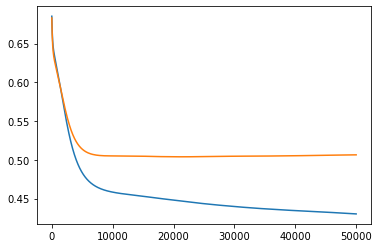

In [19]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

And we're finally finished! Congratulations! You’ve made huge progress in demystifying the complex world of deep learning. I hope you enjoyed reading this book as much as I enjoyed writing it! It took me years to learn what was necessary to write a book which was an easy-to-read introduction to neural networks for coders. Although I tried super hard to explain every little detail in this book, I understand that some concepts are difficult to grasp. It's best to try going over the hard parts several times and then try rewriting the code yourself without looking.

Until the next book!